<a href="https://colab.research.google.com/github/badhanamitroy/AI-Image-Detector/blob/main/AI_Gen_Image_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI Image Detector')

In [3]:
!pip install tensorflow matplotlib split-folders

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/AI Image Detector/Train_Data',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/AI Image Detector/Test_Data',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers

# Add classification head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_data, validation_data=val_data, epochs=10)


Found 6164 images belonging to 2 classes.
Found 385 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 1172s 6s/step - accuracy: 0.8773 - loss: 0.3238 - val_accuracy: 0.9948 - val_loss: 0.0473
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 108s 559ms/step - accuracy: 0.9855 - loss: 0.0550 - val_accuracy: 0.9922 - val_loss: 0.0263
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 113s 586ms/step - accuracy: 0.9936 - loss: 0.0287 - val_accuracy: 0.9974 - val_loss: 0.0142
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 114s 592ms/step - accuracy: 0.9954 - loss: 0.0194 - val_accuracy: 0.9948 - val_loss: 0.0151
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 115s 597ms/step - accuracy: 0.9964 - loss: 0.0164 - val_accuracy: 0.9974 - val_loss: 0.0077
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 113s 584ms/step - accuracy: 0.9970 - loss: 0.0108 - val_accuracy: 0.9974 - val_loss: 0.0066
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 112s 579ms/step - accuracy: 0.9976 - loss: 0.0115 - val_accuracy: 0.9974 - val_loss: 0.0077
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 109s 566ms/step - accuracy: 0.9981 - l

Model saved successfully!


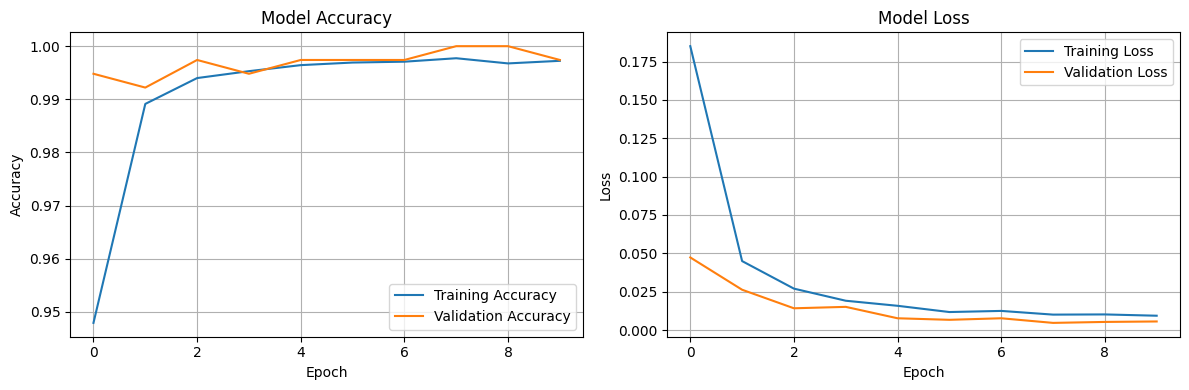

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 727ms/step - accuracy: 1.0000 - loss: 0.0034

Validation Accuracy: 100.00%
Validation Loss: 0.0025


In [17]:
# ===== PART 2: Save and evaluate the model =====
import matplotlib.pyplot as plt

# Save the trained model
model.save('ai_image_detector_model.h5')
print("Model saved successfully!")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f"\nValidation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

### Prepare image for prediction

Now, let's add code to allow you to upload an image and then use the `predict_image` function to test it.

Saving 3HXaOzVA.jpg to 3HXaOzVA.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


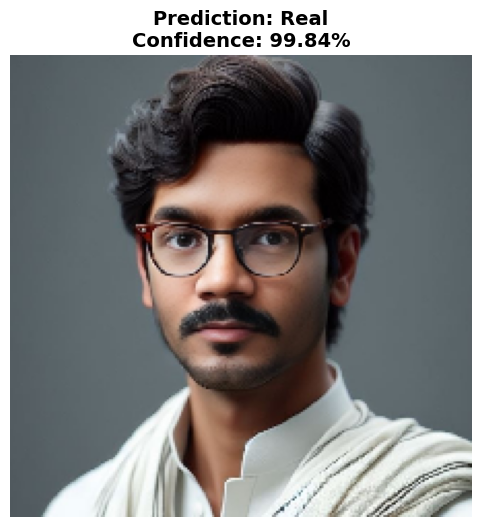


Result for 3HXaOzVA.jpg:
Prediction: Real
Confidence: 99.84%


In [31]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Upload an image from your local machine
uploaded = files.upload()

for fn in uploaded.keys():
    # Get the path to the uploaded image
    img_path = fn

    # Make a prediction using the predict_image function
    prediction, label, confidence = predict_image(img_path)

    print(f"\nResult for {img_path}:")
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence*100:.2f}%")